In [66]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from skimage.color import rgb2hsv, rgb2gray
from skimage import transform, feature
from skimage.io import imread
from skimage.transform import resize

## Horizontalité vs Proportion de bleu
Dans ce notebook nous essayons de distinguer les images de mer des autres images à partir d'un facteur d'horizontalité et d'une proportion de bleu calculée à partir de l'HSV d'une image

## Proportion de couleurs
Pour le calcul de la proportion de bleu, nous allons nous fier à l'espace de couleur HSV (Hue, Saturation, Value), qui permet l'analyse d'un seul cannal de valeur (le hue) plutôt que 3 (r, g, b) lorsqu'on souhaite isoler des couleurs.

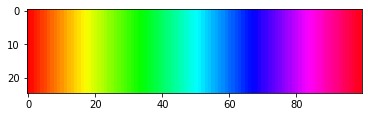

In [67]:
grad = np.arange(0, 1, 0.01)
im_grad = np.full((25, 100), grad)
dump = plt.imshow(im_grad, cmap='hsv')

In [68]:
# bleues : 150 -> 240; verts : 75 -> 150; jaunes : 30 -> 65
def color_perc(imarray_rgb, lt, ht):
    # calcul du pourcentage de bleu à l'aide d'un masque
    imarray_rgb = imarray_rgb[:, :, :3]
    imarray_hue = rgb2hsv(imarray_rgb)[:, :, 0] * 360
    nb_px = imarray_hue.shape[0] * imarray_hue.shape[1]
    return np.sum(((imarray_hue > lt) & (imarray_hue < ht)).astype(int)) / nb_px


# rouges: 300 -> 360, 0 -> 30;
def red_perc(imarray_rgb):
    imarray_rgb = imarray_rgb[:, :, :3]
    imarray_hue = rgb2hsv(imarray_rgb)[:, :, 0] * 360
    nb_px = imarray_hue.shape[0] * imarray_hue.shape[1]
    return np.sum(((imarray_hue > 310) | (imarray_hue < 35)).astype(int)) / nb_px

## Horizontalité, Verticalité, Transversalité

In [69]:
def angle_to_hori(p1, p2):
    # source : https://stackoverflow.com/questions/7586063/how-to-calculate-the-angle-between-a-line-and-the-horizontal-axis
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    return np.degrees(theta)


def compute_hvt_props(imarray):
    """
    Nécessite une image en niveaux gris
    """
    # source : https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html
    canny_imarray = feature.canny(imarray, 5, 1, 19)  # filtre pour retrouver les contours
    lines = transform.probabilistic_hough_line(canny_imarray, threshold=10, line_length=25, line_gap=10)
    h, v, t = 0, 0, 0
    for p0, p1 in lines:
        angle = np.abs(angle_to_hori(p0, p1))
        if 60 <= angle <= 120 or 240 <= angle <= 300:
            v += 1
        elif 0 <= angle <= 20 or 340 <= angle <= 360 or 160 <= angle <= 200:
            h += 1
        else:
            t += 1
    tot = len(lines) + 1
    return h / tot, v / tot, t / tot, canny_imarray

##### Visualisation du filtre Canny

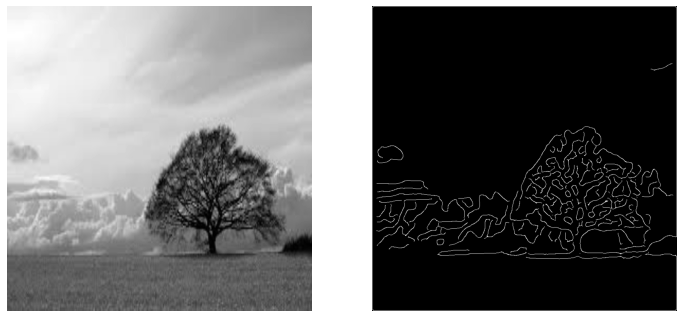

In [70]:
im_mer = rgb2gray(resize(imread("./Data/Ailleurs/dfr.jpeg"), (800, 800), anti_aliasing=True)) * 255
h, v, t, canny_mer = compute_hvt_props(im_mer[0:, :])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(im_mer, cmap='gray')
ax[1].imshow(canny_mer, cmap='gray')

## Préparation des données

In [71]:
def compute_data(X, y, directory, elementsClass):
    for file in tqdm(os.listdir(directory)):
        imarray = resize(imread(directory + "/" + file), (800, 800), anti_aliasing=True)
        b_perc = color_perc(imarray[250:, :], 175, 280)
        g_perc = color_perc(imarray[:, :], 70, 170)
        r_per = red_perc(imarray)
        imarray_l = rgb2gray(imarray[:, :, :3]) * 255
        # im_blurred = nd.median_filter(imarray_l, size=13)
        h, v, t, _ = compute_hvt_props(imarray_l[150:,:])
        X.append([g_perc, b_perc, r_per, h, v, t])
        y.append(elementsClass)

In [72]:
X = []
y = []

compute_data(X, y, "./Data/Ailleurs", 0)
compute_data(X, y, "./Data/Mer", 1)

100%|██████████| 246/246 [02:50<00:00,  1.44it/s]


## Comparaison de classifieurs

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [74]:
pipe = Pipeline([('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'classifier__kernel': ['rbf', 'linear'], 'classifier__gamma': [0.01, 0.1, 1],
     'classifier__C': [0.01, 0.1, 1]},

    {'classifier': [GaussianNB()]},

    {'classifier': [LogisticRegression()], 'classifier__penalty': ['l2', 'l1'], 'classifier__C': [1.0, 0.8, 0.5, 0.3],
     'classifier__solver': ['liblinear'], 'classifier__max_iter': [100, 500, 1000]},

    {'classifier': [MLPClassifier()], 'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
     'classifier__solver': ['adam', 'sgd'], 'classifier__max_iter': [1000, 2000]},

    {'classifier': [RandomForestClassifier()], 'classifier__criterion': ["gini", "entropy"],
     'classifier__max_depth': [5, 10, 15], "classifier__min_samples_split": [2, 5, 10]}
]

In [75]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X,y)
print(grid.best_params_, grid.best_score_)

{'classifier': MLPClassifier(max_iter=2000), 'classifier__activation': 'relu', 'classifier__max_iter': 2000, 'classifier__solver': 'adam'} 0.7797979797979798


## Résultats

In [76]:
def plot_results(clf_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('Résultats')
    ax1.hist(clf_scores)
    ax2.boxplot(clf_scores)

    print("Moyenne : " + str(np.mean(clf_scores)) + ", Variance : " + str(np.var(clf_scores))
          + ", Écart-type : " + str(np.std(clf_scores)))

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Moyenne : 0.7615151515151514, Variance : 0.0014424956637077843, Écart-type : 0.03798020094348876


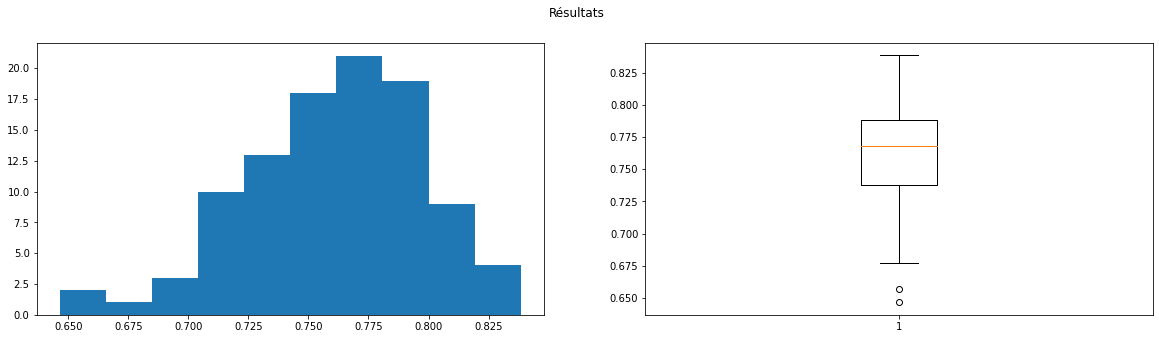

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifieur = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5)

nb_runs = 100
clf_scores = []
for i in tqdm(range(nb_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    clf_scores.append(accuracy_score(y_test, y_predits))
plot_results(clf_scores)

## Export

In [78]:
classifieur.fit(X,y)
from joblib import dump
dump(classifieur, 'horizontality.joblib')

['horizontality.joblib']